# TP2: Stacking
___
Lucas Nahuel Raimondi

Manuel Davila

Dolores Levi

# Imports

In [ ]:
!pip install 'dtreeviz'

In [ ]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/TP2/datasets/train.csv

--2023-11-29 22:12:30--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/TP2/datasets/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72229641 (69M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  68.88M   229MB/s    in 0.3s    

2023-11-29 22:12:32 (229 MB/s) - ‘train.csv’ saved [72229641/72229641]



In [ ]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/TP2/datasets/test.csv

--2023-11-29 22:12:32--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/TP2/datasets/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11054515 (11M) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]  10.54M  --.-KB/s    in 0.07s   

2023-11-29 22:12:32 (162 MB/s) - ‘test.csv’ saved [11054515/11054515]



In [ ]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import sklearn.naive_bayes
import xgboost as xgb

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline


#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Preprocesamiento

In [ ]:
df = pd.read_csv('train.csv')
df_filtrado = df.copy()

In [ ]:
df_filtrado['sentimiento_encodeado'] = df_filtrado['sentimiento'].map({'positivo': 1, 'negativo': 0})
df_filtrado = df_filtrado.drop('sentimiento', axis=1)
df_filtrado.head(3)

,ID,review_es,sentimiento_encodeado
0,0,Uno de los otros críticos ha mencionado que de...,1
1,1,Una pequeña pequeña producción.La técnica de f...,1
2,2,Pensé que esta era una manera maravillosa de p...,1


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_filtrado.review_es,
                                                    df_filtrado.sentimiento_encodeado,
                                                    test_size = 0.3,
                                                    random_state = 0,
                                                    shuffle=True)

In [ ]:
tf_idf = TfidfVectorizer(ngram_range = (1,2),
                         min_df = 0.01,
                         max_df = 0.5,
                         lowercase = True)


x_train_vectorizado = tf_idf.fit_transform(x_train)
x_test_vectorizado = tf_idf.transform(x_test)

# Entrenamiento y Predicción

In [ ]:
from sklearn.ensemble import StackingClassifier

#Modelos Base
base_models = [('random_forest', RandomForestClassifier(criterion='gini')),
               ('xgbost', xgb.XGBClassifier(subsample=0.9,
                              objective='binary:logistic',
                              learning_rate=0.01)),
               ('bayes', sklearn.naive_bayes.MultinomialNB(force_alpha = False,
                                                fit_prior = True,
                                                class_prior = None,
                                                alpha = 1
                                                ))]

#Meta Modelo
meta_model = sklearn.naive_bayes.MultinomialNB(force_alpha = False,
                                                fit_prior = True,
                                                class_prior = None,
                                                alpha = 1
                                                )

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=5,
                                    verbose=2)

stacking_model.fit(x_train_vectorizado,y_train)

StackingClassifier(cv=5,
                   estimators=[('random_forest', RandomForestClassifier()),
                               ('xgbost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importan...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('bayes',
                                MultinomialNB(alpha=1, force_alpha=False))],
                   final_estimator=MultinomialNB(alpha=1, force_alpha=False),
                   passthrough=True, verbose=2)

In [ ]:
y_pred = stacking_model.predict(x_test_vectorizado)
#Valores Predichos
y_pred

array([1, 0, 1, ..., 1, 1, 0])

In [ ]:
y_test.values

array([1, 0, 0, ..., 1, 1, 0])

In [ ]:
ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados.head(10)

,test,pred
0,1,1
1,0,0
2,0,1
3,1,1
4,1,1
5,0,0
6,1,1
7,0,1
8,1,0
9,0,0


Text(50.722222222222214, 0.5, 'True')

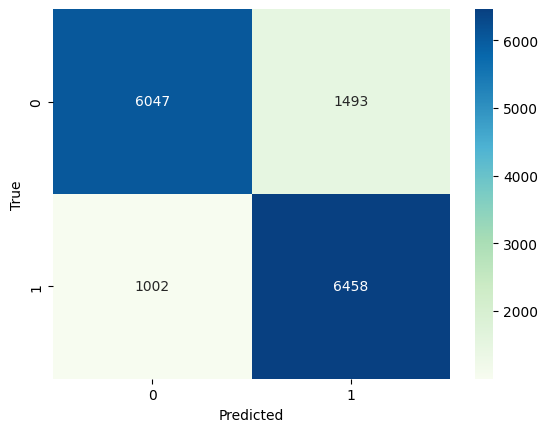

In [ ]:
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8336666666666667
Recall: 0.8656836461126005
Precision: 0.8122248773739152
f1 score: 0.8381026539484783


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      7540
           1       0.81      0.87      0.84      7460

    accuracy                           0.83     15000
   macro avg       0.84      0.83      0.83     15000
weighted avg       0.84      0.83      0.83     15000



# Test Prediction

In [ ]:
df_test = pd.read_csv("test.csv")

df_test_filtrado = df_test.copy()

In [ ]:
test_vectorizado = tf_idf.transform(df_test_filtrado.review_es)
test_pred = stacking_model.predict(test_vectorizado)

In [ ]:
test_pred

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
df_test_ids = df_test['ID']

In [ ]:
data = {'ID': df_test_ids, 'sentimiento': test_pred}
df_final = pd.DataFrame(data)

In [ ]:
df_final['sentimiento'] = df_final['sentimiento'].map({1: 'positivo', 0: 'negativo'})

In [ ]:
df_final.to_csv('submission.csv', index=False)